In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [3]:

%load_ext kedro.ipython

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [4]:
movies_metadata = catalog.load("movies_metadata")

print(movies_metadata.head())

[10/28/25 11:44:09] INFO     Loading data from movies_metadata (CSVDataset)...                 ]8;id=546153;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=454923;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

In [5]:
# Revisar columnas
print(movies_metadata.columns)

# Crear main_genre
import ast

def get_main_genre(genre_str):
    try:
        genres = ast.literal_eval(genre_str)  # Convierte string a lista de diccionarios
        if isinstance(genres, list) and len(genres) > 0:
            return genres[0]['name']  # Tomamos el primer género como principal
        else:
            return None
    except:
        return None

movies_metadata['main_genre'] = movies_metadata['genres'].apply(get_main_genre)

# Revisar si se creó correctamente
print(movies_metadata[['genres', 'main_genre']].head())


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')
                                              genres main_genre
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...  Animation
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...  Adventure
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...    Romance
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...     Comedy
4                     [{'id': 35, 'name': 'Comedy'}]     Comedy


In [6]:
# Importaciones
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset
movies_metadata = catalog.load("movies_metadata")

# 1️⃣ Crear la variable objetivo 'high_rating'
movies_metadata['high_rating'] = (movies_metadata['vote_average'] > 6).astype(int)

# 2️⃣ Seleccionar columnas numéricas para las características
numeric_cols = ['vote_count', 'popularity', 'runtime', 'budget' ]  # ejemplo de columnas numéricas
movies_metadata[numeric_cols] = movies_metadata[numeric_cols].apply(pd.to_numeric, errors='coerce')

# 3️⃣ Eliminar filas con valores nulos
movies_metadata = movies_metadata.dropna(subset=numeric_cols + ['high_rating'])

# 4️⃣ Definir X e y
X = movies_metadata[numeric_cols]
y = movies_metadata['high_rating']

# 5️⃣ Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# 6️⃣ Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7️⃣ Entrenar Logistic Regression
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_scaled, y_train)

# 8️⃣ Predicciones
y_pred = model.predict(X_test_scaled)
y_scores = model.predict_proba(X_test_scaled)[:, 1]

# 9️⃣ Métricas de rendimiento
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClasificación:\n", classification_report(y_test, y_pred))



[10/28/25 11:44:27] INFO     Loading data from movies_metadata (CSVDataset)...                 ]8;id=324083;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=783446;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

Accuracy: 0.6050349526590567

Clasificación:
               precision    recall  f1-score   support

           0       0.60      0.73      0.66     11721
           1       0.62      0.47      0.53     10881

    accuracy                           0.61     22602
   macro avg       0.61      0.60      0.60     22602
weighted avg       0.61      0.61      0.60     22602



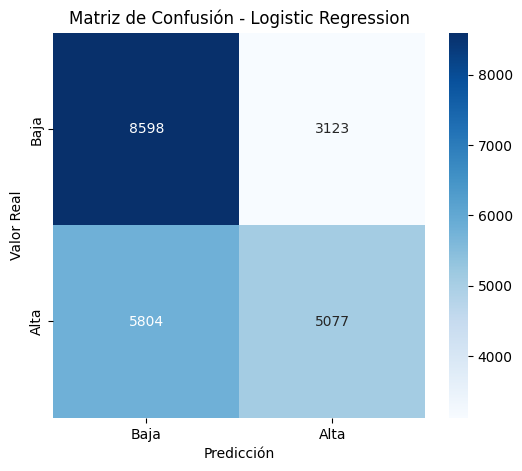

In [7]:
# 10️⃣ Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baja', 'Alta'], yticklabels=['Baja', 'Alta'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Logistic Regression')
plt.show()

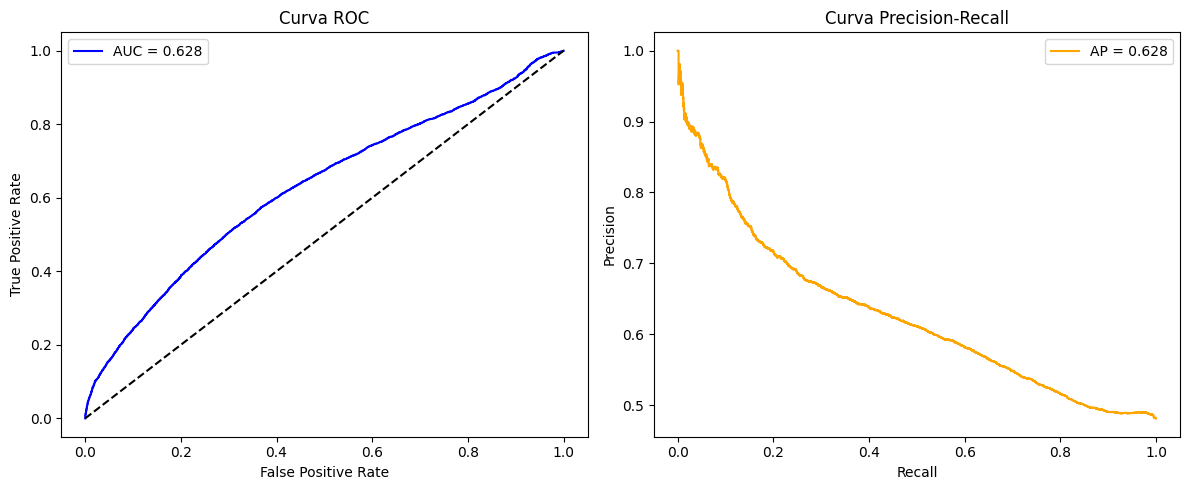

In [8]:

# 11️⃣ Curva ROC y Precision-Recall
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_prec = average_precision_score(y_test, y_scores)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', color='blue')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()

plt.subplot(1,2,2)
plt.plot(recall, precision, label=f'AP = {avg_prec:.3f}', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Predicción de clases (0 = bajo, 1 = alto)
y_pred = model.predict(X_test_scaled)

# Predicción de probabilidades (opcional)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probabilidad de ser alto rating


Conclusión:
El modelo de clasificación indica que las películas con mayor puntaje promedio (vote_average > 6) pueden predecirse con una precisión moderada (61%) usando variables como vote_count, popularity y runtime. Esto sugiere que el número de votos y la popularidad son factores relevantes para determinar si una película tendrá una calificación alta o baja

In [10]:
import pandas as pd

# Cargar el dataset
data = pd.read_csv("data/movies_metadata.csv")

# Mostrar todas las columnas y su tipo de dato
print("\n🔹 Columnas disponibles:")
print(data.columns.tolist())

print("\n🔹 Tipos de datos:")
print(data.dtypes)

# Mostrar las primeras filas para ver cómo se ven los valores
print("\n🔹 Primeras filas:")
print(data.head())


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│    1 import pandas as pd                                                                         │
│    2                                                                                             │
│    3 # Cargar el dataset                                                                         │
│ ❱  4 data = pd.read_csv("data/movies_metadata.csv")                                              │
│    5                                                                                             │
│    6 # Mostrar todas las columnas y su tipo de dato                                              │
│    7 print("\n🔹 Columnas disponibles:")                                                         │
│                                                                                                  │
│ C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\pandas\io\parsers │
│ \readers.py:1026 in read_csv                                                                     │
│                                                                                                  │
│   1023 │   )                                                                                     │
│   1024 │   kwds.update(kwds_defaults)                                                            │
│   1025 │                                                                                         │
│ ❱ 1026 │   return _read(filepath_or_buffer, kwds)                                                │
│   1027                                                                                           │
│   1028                                                                                           │
│   1029 # iterator=True -> TextFileReader                                                         │
│                                                                                                  │
│ C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\pandas\io\parsers │
│ \readers.py:620 in _read                                                                         │
│                                                                                                  │
│    617 │   _validate_names(kwds.get("names", None))                                              │
│    618 │                                                                                         │
│    619 │   # Create the parser.                                                                  │
│ ❱  620 │   parser = TextFileReader(filepath_or_buffer, **kwds)                                   │
│    621 │                                                                                         │
│    622 │   if chunksize or iterator:                                                             │
│    623 │   │   return parser                                                                     │
│                                                                                                  │
│ C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\pandas\io\parsers │
│ \readers.py:1620 in __init__                                                                     │
│                                                                                                  │
│   1617 │   │   │   self.options["has_index_names"] = kwds["has_index_names"]                     │
│   1618 │   │                                                                                     │
│   1619 │   │   self.handles: IOHandles | None = None                                             │
│ ❱ 1620 │   │   self._engine = self._make_engine(f, self.engi